<a href="https://colab.research.google.com/github/fanurs/pytorch-notes/blob/main/notes/tut03_automatic_differentiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic differentiation

There are at least three ways to evaluate the derivative of a function: symbolic differentiation, numerical differentiation, and automatic differentiation.

Symbolic differentiation is what we usually first learned in calculus. However, for most applications, it is difficult for computer to automate this process.

Numerical differentiation uses the method of finite differences to approximate a derivative,
$$ \frac{df(x)}{dx} \approx \frac{f(x + \delta x) - f(x)}{\delta x} \ . $$
But this approach introduces round-off errors.

Automatic differentiation (AD) exploits the fact that every function can be computed using a chain of arithmetic operations. Hence, using the chain rule, it is possible to evaluate the resulting derivative.

AD is usually faster and numerically more stable.

Any machine learning algorithm is essentially some kind of optimization problem. This is why having a reliable way to compute a gradient is very useful. PyTorch offers an automatic differeniation package called [`torch.autograd`](https://pytorch.org/docs/stable/autograd.html) to handle these tasks.

# Differentiating a single-variable function

In [1]:
import matplotlib.pyplot as plt
import torch as th

## Setting up the tensors

Let's start by using PyTorch to solve a simple example. Given $g(x) = x^2$, evaluate
$$ \frac{d}{dx}g(x) $$
over the domain $x\in[-3, 3]$.

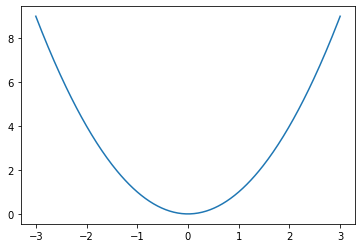

In [2]:
x = th.linspace(-3, 3, 301)
y = x**2
plt.plot(x, y)
plt.show()

So far there is no differentiation involved. We are just plotting out the function $g(x) = x^2$ over the interval $x\in[-3, 3]$ with 301-point sampling:
$$ -3.00, -2.98, -2.96, \ldots, 2.98, 3.00 \ . $$

To take the derivative, we would have to update an attribute, `torch.Tensor.requires_grad` to `True`. To propagate this attribute, we shall recompute `y` too.

In [3]:
x.requires_grad = True
y = x**2
x[0]

tensor(-3., grad_fn=<SelectBackward0>)

Notice that each entry of `x` is now a tensor that also contains the `grad_fn` property. This is where `autograd` will do its magic. But for now, it means if we try to plot by typing `plot.plot(x, y)`, an error will be raised. For `plot()` to work properly, we have to strip off the `grad_fn` part from the tensors. PyTorch provides us a `detach()` function for that.

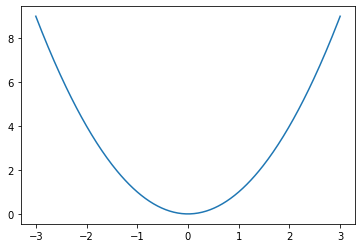

In [4]:
plt.plot(x.detach(), y.detach())
plt.show()

## Taking derivative as gradient

So how can we actually take the derivative of $g(x)$?

PyTorch's autograd can only compute the gradient,
$$ \nabla f(x_1, x_2, \ldots, x_n) =
\begin{bmatrix}
\partial_1 f \\
\partial_2 f \\
\vdots \\
\partial_n f \\
\end{bmatrix} \ .
$$

On the other hand, we have $g(x)$ evaluated at 301 discrete points,
$$ x_k = -3 + 0.02 \cdot (k - 1) $$
for all $k = 1, 2, \ldots, 301$. And we want to know its derivative $g'(x)$ at the same 301 discrete points,
$$ g'(x_1), g'(x_2), \ldots, g'(x_{301}) \ . $$

The trick is to construct the sum
$$ f(x_1, x_2, \ldots, x_{301}) \equiv g(x_1) + g(x_2) + \cdots + g(x_{301}) \ . $$
Then the gradient of this sum would give us
$$ \nabla f(x_1, x_2, \ldots, x_{301}) =
\begin{bmatrix}
\partial_1 f \\
\partial_2 f \\
\vdots \\
\partial_{301} f \\
\end{bmatrix} =
\begin{bmatrix}
g'(x_1) \\
g'(x_2) \\
\vdots \\
g'(x_{301}) \\
\end{bmatrix} \ .
$$

In other words, instead of treating $g(x)$ as a single-variable function that depends on $x$, we may view $x_1, x_2, \ldots, x_{301}$ as independent variables for the sum $f$. This is why constructing the tensors, we specified `requires_grad = True` for $x$, too.

Following the trick, we first compute the sum of all function values evaluated at the 301 discrete points:

In [5]:
total = y.sum()
total

tensor(909.0200, grad_fn=<SumBackward0>)

Next, we calculate the gradient. The function for this is `torch.Tensor.backward()`. The reason for this weird name is because computation of a gradient in a neural network often happens in a process called "backward propagation".

In [6]:
total.backward()

The `backward()` function does not actually return anything. Instead, it traces back all the tensors that were used to build up `total` (i.e. `x` and `y`), and takes the partial derivatives with respective to each component that has a `grad_fn` property (traced computation history) to construct the gradient of `total`. The final result will be stored as `grad` attribute:

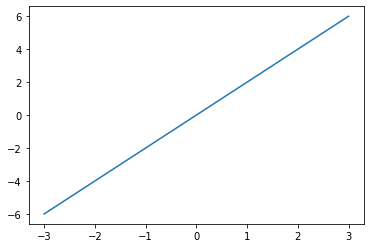

In [7]:
plt.plot(x.detach(), x.grad.detach())
plt.show()

This is a line for $2x$, which is what we would expect for the derivative of $g(x) = x^2$.

Let us quickly apply all these steps to some more interesting function, $h(x) = \sin(x^2)$:

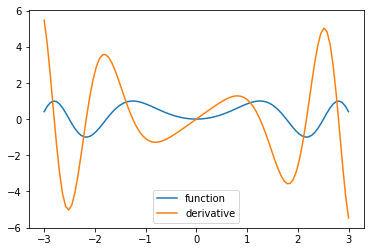

In [8]:
x = th.linspace(-3, 3, 100, requires_grad=True)
y = th.sin(x**2)
y.sum().backward()
plt.plot(x.detach(), y.detach(), label='function')
plt.plot(x.detach(), x.grad.detach(), label='derivative')
plt.legend()
plt.show()

# Comparing automatic differentiation (AD) and finite difference method (FDM)

Consider a function,
$$ f(x) = \sin(3x^2) \ . $$
We are interested in the derivative $f'(x)$ over the interval $x \in [0, 2\pi]$.

In [9]:
def model(x):
    return th.sin(3 * x**2)

## Finite difference method (FDM)

When using FDM, the number of grid points directly affects the accuracy of our derivatives.

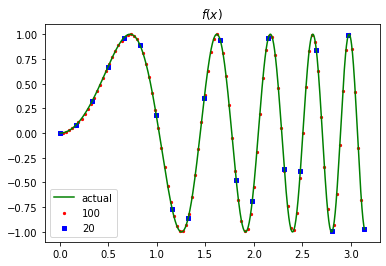

In [10]:
x_100 = th.linspace(0, th.pi, 100)
x_20 = th.linspace(0, th.pi, 20)
f_100 = model(x_100)
f_20 = model(x_20)

x = th.linspace(0, th.pi, 1000)
plt.title(r'$f(x)$')
plt.plot(x, model(x), color='green', label='actual')
plt.scatter(x_100,f_100, marker='o', s=5, color='red', label='100')
plt.scatter(x_20, f_20, marker='s', s=10, color='blue', label='20')
plt.legend()
plt.show()

The derivatives can be estimated using the central difference:
$$ \frac{d}{dx}f(x_i) \approx \frac{f(x_{i+1}) - f(x_{i-1})}{2\delta x} $$

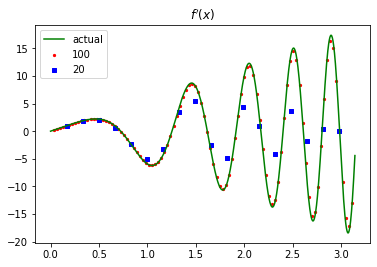

In [11]:
deriv_100 = 0.5 * (f_100[2:] - f_100[:-2]) / (x_100[1] - x_100[0])
deriv_20 = 0.5 * (f_20[2:] - f_20[:-2]) / (x_20[1] - x_20[0])

x = th.linspace(0, th.pi, 1000)
plt.title(r"$f'(x)$")
plt.plot(x, 6 * x * th.cos(3 * x**2), color='green', label='actual')
plt.scatter(x_100[1:-1], deriv_100, marker='o', s=5, color='red', label='100')
plt.scatter(x_20[1:-1], deriv_20, marker='s', s=10, color='blue', label='20')
plt.legend()
plt.show()

In this plot, we have compared both numerical results against the symbolic result of
$$ \frac{d}{dx}f(x) = 6x\cos(3x^2) \ . $$
As we can see, the accuracy for 20-point grid is quite terrible.

## Automatic differentiation (AD)

Let's see how AD would perform on both 100-point and 20-point grids.

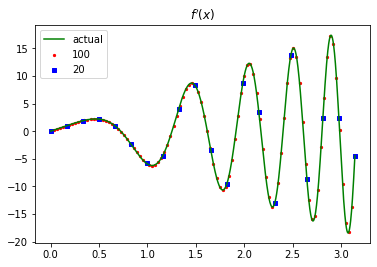

In [12]:
x_100.requires_grad = True
x_20.requires_grad = True
model(x_100).sum().backward()
model(x_20).sum().backward()

x = th.linspace(0, th.pi, 1000)
plt.title(r"$f'(x)$")
plt.plot(x, 6 * x * th.cos(3 * x**2), color='green', label='actual')
plt.scatter(x_100.detach(), x_100.grad.detach(), marker='o', s=5, color='red', label='100')
plt.scatter(x_20.detach(), x_20.grad.detach(), marker='s', s=10, color='blue', label='20')
plt.legend()
plt.show()

As we can see, the accuracy of AD is independent of the number of grid points.

## Remarks

Be cautious! We are not trying to tell you that FDM is always inaccurate. As long as we have access to the evaluation of $f(x)$, e.g. $f(x)$ is not too expensive to compute, we can simply evaluate the derivative according to
$$ \frac{d}{dx}f(x_i) \approx \frac{f(x_i + \delta x) - f(x_i - \delta x)}{\delta x} \ , $$
where $\delta x > 0$ can be made as small as we want until the estimated derivative attains the desired precision.

The real challenge for FDM as opposed to AD is that, how do we know what $\delta x$ to use? A common practice is to check the convergence iteratively. More specifically, one can use $\delta x = 0.1, 0.01, 0.001, \ldots$ iteratively, until the estimated derivatives converge within some tolerance. But this is very inefficient. AD, on the other hand, can "automatically" figure out the derivatives accurately.

Of course, AD also has its limitation. AD calculates the derivative using the chain rule for each primitive function that builds up the final functional expression. This means that when implementing $f(x)$, we are limited to using a finite set of functions to construct $f(x)$. In some cases, $f(x)$ might not have a closed form solution, and that would make it very difficult or simply impossible to use AD anymore. AD cannot be used for functions that are constructed empirically, for example, if $f(t)$ represents the live temperature of a town as a function of time $t$, then it is unlikely for us to precisely construct $f(t)$ using elementary functions (though approximation or interpolation may be good enough).

PyTorch has provided users a rather long list of functions that can be used to with AD (see https://pytorch.org/docs/stable/torch.html). But if there is a function that cannot be constructed from all those listed functions, then you are out of luck. The following code cell, we show that feeding a tensor with `requires_grad = True` into non-PyTorch functions (e.g. NumPy functions) will give a `RuntimeError`.

In [13]:
import numpy as np
def non_torch_model(x):
    return np.sin(x)

x = th.linspace(0, th.pi, 5)
display(non_torch_model(x)) # no error

x.requires_grad = True
display(non_torch_model(x)) # RuntimeError

tensor([ 0.0000e+00,  7.0711e-01,  1.0000e+00,  7.0711e-01, -8.7423e-08])

RuntimeError: ignored

# References

- https://en.wikipedia.org/wiki/Automatic_differentiation